## Imports and Setup

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from scipy import stats
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [157]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

## Data Exploration and Cleaning

In [158]:
house_prices_df.info()
house_prices_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [159]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

print(house_prices_df.fireplacequ.unique())

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43
[None 'TA' 'Gd' 'Fa' 'Ex' 'Po']


In [160]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


So, we see that we have both numerical and non numerical data, as well as 19 features that are missing data. 

##  Exploratory Data Analysis and Feature Engineering

In [161]:
# Create a lsit of ou categorical variables
cat_vars = ['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition']

In [162]:
# 
def anova_test(df_in, variables):
    # initialize empty data frame
    # this will be the return variable
    df_anv = pd.DataFrame()
    df_anv['feature'] = variables
    pvals = []
    
    # iterate through categorical variables
    for v in variables:
        
        # initialize empty samples list
        samples = [];
        
        # iterate through each feature's levels
        for level in df_in[v].unique():
            
            # collect the saleprices for each variable's levels
            prices = df_in[df_in[v] == level].saleprice.values
            samples.append(prices)
        
        # execute one-way ANOVA test and get p-value
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
        
    df_anv['pval'] = pvals
    return df_anv.sort_values('pval')

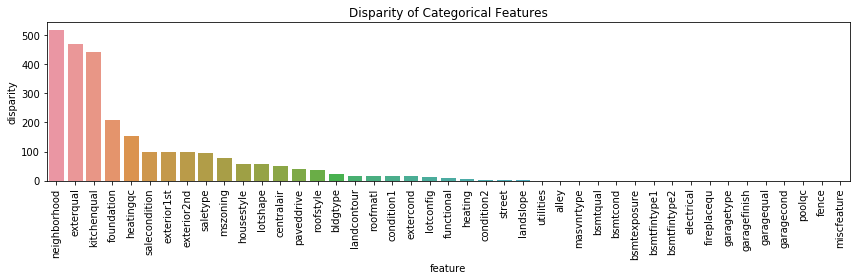

In [163]:
ENABLE_PLOTS = True
# execute anova test
a = anova_test(house_prices_df, cat_vars)

# calculate and add disparity
a['disparity'] = np.log(1/a['pval'])

if ENABLE_PLOTS:
    # set figure size
    plt.rcParams['figure.figsize'] = (12,4)
    
    sns.barplot(data=a, x='feature', y='disparity')
    plt.title('Disparity of Categorical Features')
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.savefig('categorical_variables_ranked_by_disparity')
    plt.show()

In [164]:
keep_categorical = ['neighborhood', 'exterqual', 'kitchenqual', 'foundation', 'heatingqc', 'salecondition', 'exterior1st', 'exterior2nd', 'saletype', 'mszoning', 'housestyle', 'lotshape', 'centralair', 'paveddrive']

In [165]:
house_prices_cat_df = house_prices_df.copy()
for col in keep_categorical :
    house_prices_cat_df = pd.concat([house_prices_cat_df, pd.get_dummies(house_prices_cat_df[col], prefix=col, drop_first=True)], axis=1)
    dummy_column_names = list(pd.get_dummies(house_prices_cat_df[col], prefix=col, drop_first=True).columns)
    
house_prices_cat_df.drop(cat_vars, axis=1, inplace=True)
house_prices_cat_df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,housestyle_2.5Unf,housestyle_2Story,housestyle_SFoyer,housestyle_SLvl,lotshape_IR2,lotshape_IR3,lotshape_Reg,centralair_Y,paveddrive_P,paveddrive_Y
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,1,0,0,0,0,1,1,0,1
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,0,0,0,1,1,0,1
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,1,0,0,0,0,0,1,0,1
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,1,0,0,0,0,0,1,0,1
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,1,0,0,0,0,0,1,0,1


In [166]:
house_prices_cat_df.corrwith(house_prices_cat_df.saleprice).sort_values(ascending=False).head(50)

saleprice                1.000000
overallqual              0.790982
grlivarea                0.708624
garagecars               0.640409
garagearea               0.623431
totalbsmtsf              0.613581
firstflrsf               0.605852
fullbath                 0.560664
totrmsabvgrd             0.533723
yearbuilt                0.522897
yearremodadd             0.507101
foundation_PConc         0.497734
garageyrblt              0.486362
masvnrarea               0.477493
fireplaces               0.466929
exterqual_Gd             0.452466
neighborhood_NridgHt     0.402149
bsmtfinsf1               0.386420
saletype_New             0.357509
salecondition_Partial    0.352060
lotfrontage              0.351799
neighborhood_NoRidge     0.330424
wooddecksf               0.324413
kitchenqual_Gd           0.321641
secondflrsf              0.319334
openporchsf              0.315856
exterior2nd_VinylSd      0.306389
exterior1st_VinylSd      0.305009
halfbath                 0.284108
lotarea       

### Drop features that dont contain enough data

drop_list = ['alley', 'poolqc', 'fence', 'miscfeature']

for col in drop_list :
    house_prices_df.drop(col, axis=1, inplace=True)
    
house_prices_df.head()

Text(0, 0.5, 'count')

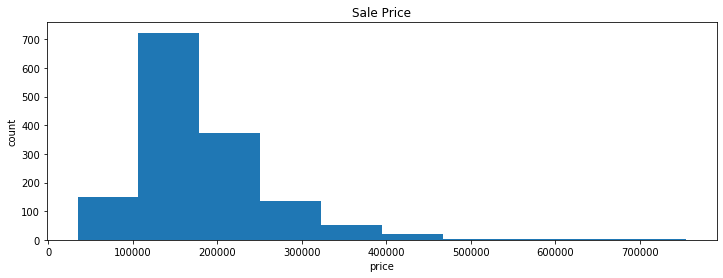

In [167]:
plt.hist(house_prices_df['saleprice'])
plt.title('Sale Price')
plt.xlabel('price')
plt.ylabel('count')

We can see that the target variable, saleprice, is not normally distributed. 

### Create dummy columns for all non numeric features

In [168]:
# create new data frame for numeric columns plus dummies
house_prices_dummies_df = house_prices_df.copy()

for col in non_numeric_columns :
    house_prices_dummies_df = pd.concat([house_prices_dummies_df, pd.get_dummies(house_prices_dummies_df[col], prefix=col, drop_first=True)], axis=1)
    dummy_column_names = list(pd.get_dummies(house_prices_dummies_df[col], prefix=col, drop_first=True).columns)

In [169]:
# drop non numeric columsn from dummy data frame
for col in non_numeric_columns :
    house_prices_dummies_df.drop(col, axis=1, inplace = True)
house_prices_dummies_df.head()

house_prices_dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 247 entries, id to salecondition_Partial
dtypes: float64(3), int64(35), uint8(209)
memory usage: 731.6 KB


In [170]:
house_prices_dummies_df.corr()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,saletype_ConLI,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.058765,-0.020738,-0.018998,0.038920,0.026133,-0.034852,-0.009018,0.004865,0.015881,-0.020738
mssubclass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.001244,0.014005,-0.045156,-0.014555,0.026359,0.016241,0.030002,0.000983,0.024359,-0.051068
lotfrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.014169,-0.051807,0.128311,-0.023466,-0.094298,-0.037030,-0.019817,0.016684,-0.076258,0.126571
lotarea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.001076,-0.015040,0.020039,-0.005722,-0.002292,-0.013208,0.008966,-0.010781,0.005711,0.022635
overallqual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.004269,-0.021172,0.327412,-0.057962,-0.225013,-0.041677,-0.044950,-0.025515,-0.143282,0.323295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
salecondition_AdjLand,-0.034852,0.016241,-0.037030,-0.013208,-0.041677,-0.038888,-0.045601,-0.040294,-0.011959,-0.014874,...,-0.003073,-0.003073,-0.015827,-0.002378,0.020457,1.000000,-0.004772,-0.006177,-0.112080,-0.016038
salecondition_Alloca,-0.009018,0.030002,-0.019817,0.008966,-0.044950,-0.033444,-0.010104,-0.020727,-0.010116,0.021369,...,-0.005337,-0.005337,-0.027489,-0.004131,0.035530,-0.004772,1.000000,-0.010729,-0.194663,-0.027856
salecondition_Family,0.004865,0.000983,0.016684,-0.010781,-0.025515,-0.023873,-0.035785,-0.048056,-0.009915,0.000765,...,-0.006909,-0.006909,-0.035587,-0.005348,0.028599,-0.006177,-0.010729,1.000000,-0.252006,-0.036062
salecondition_Normal,0.015881,0.024359,-0.076258,0.005711,-0.143282,0.161642,-0.158427,-0.120577,-0.084801,-0.019560,...,-0.003139,0.027414,-0.645698,-0.097031,0.634322,-0.112080,-0.194663,-0.252006,1.000000,-0.654323


# Model building

In [171]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

X = house_prices_dummies_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]
Y = house_prices_dummies_df.saleprice

X = sm.add_constant(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

## OLS Model

In [172]:
results = sm.OLS(Y_train, X_train).fit()

results.summary()
y_preds_train = results.predict()

## Lasso Model

In [173]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=10**20.5) 
lassoregr.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


R-squared of the model on the training set is: 0.0
-----Test set statistics-----
R-squared of the model on the test set is: -0.0011035785474819981
Mean absolute error of the prediction is: 55483.66281197223
Mean squared error of the prediction is: 5656122479.7092905
Root mean squared error of the prediction is: 75207.1969940995
Mean absolute percentage error of the prediction is: 35.852314631163196


## Ridge Model

In [174]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.7617179250106554
-----Test set statistics-----
R-squared of the model in test set is: 0.8002906003695219
Mean absolute error of the prediction is: 24672.771568557673
Mean squared error of the prediction is: 1128335617.6771646
Root mean squared error of the prediction is: 33590.70731135569
Mean absolute percentage error of the prediction is: 15.821361975082798


## ElasticNet Model

In [175]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.7619483519397743
-----Test set statistics-----
R-squared of the model in test set is: 0.7999937714400863
Mean absolute error of the prediction is: 24773.754410626625
Mean squared error of the prediction is: 1130012667.7011445
Root mean squared error of the prediction is: 33615.6610481059
Mean absolute percentage error of the prediction is: 15.890209860316604


Based on the various models ran, we can rule out the Lasso model as the R-squared value for the test set is in the negatives. The Ridge model has a train set R-squared value of .764 and a test R-squared value of .783, a difference of .019. The ElasticNet model has a train R-sqaured of .765 and a test R-squared of .784, a difference of .019 as well. In this case, either model would be a good fit because the R-squared values do not indicate overfitting, and the difference between the training and test sets is minimal. 

# Incorporating New Data

For the new data being incorporated, we will be using a dataset from the Federal Reserve about interest rates and employment.

In [176]:
interest_df = pd.read_csv('C:/Users/keger/Documents/Thinkful_dataScience/supervisedLearning_regressionProblems/challenge/index.csv')
interest_df.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [177]:
interest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 10 columns):
Year                            904 non-null int64
Month                           904 non-null int64
Day                             904 non-null int64
Federal Funds Target Rate       462 non-null float64
Federal Funds Upper Target      103 non-null float64
Federal Funds Lower Target      103 non-null float64
Effective Federal Funds Rate    752 non-null float64
Real GDP (Percent Change)       250 non-null float64
Unemployment Rate               752 non-null float64
Inflation Rate                  710 non-null float64
dtypes: float64(7), int64(3)
memory usage: 70.8 KB


For our purposes, we want only want to include the unemployment rate in the model and see how that effects house prices. The interest rates dataset starts in 1954 and has unemployment data for each quarter. The housing dataset only includes the years 2006, 2007, 2008, 2009, 2010. So, we will create a new dataframe of only the year and the unemployment rates, where the year is between 2006 and 2010. Then, we will loop thorugh this new dataframe so we can average the rates from each quarter in that year, and assign those rates to a dictionary where the key value is the year. 

In [178]:
unemployment_df = interest_df[['Year', 'Unemployment Rate']]
unemployment_df = unemployment_df[unemployment_df['Year'] >= 2006]
unemployment_df = unemployment_df[unemployment_df['Year'] < 2011]
unemployment_df.dropna(inplace = True)

unemployment_rates = {}
for year in unemployment_df['Year'].unique() :
    n = 0
    total = 0
    for i in unemployment_df.index :
        if unemployment_df['Year'][i] == year :
            n+= 1
            total += unemployment_df['Unemployment Rate'][i]
    rate = total/n
    unemployment_rates[year] = rate
    
print(unemployment_rates)

{2006: 4.608333333333333, 2007: 4.616666666666667, 2008: 5.8, 2009: 9.283333333333333, 2010: 9.608333333333333}


With our averaged unemployment rates we will loop through the housing dataset and apply the unemployment rates from the year the house in the index was sold.

In [179]:
house_prices_dummies_df['unempl_rate'] = np.nan
for year in house_prices_dummies_df['yrsold'].unique() :
    for i in house_prices_dummies_df.index :
        if house_prices_dummies_df['yrsold'][i] == year :
            house_prices_dummies_df['unempl_rate'][i] = unemployment_rates[year]
            
house_prices_dummies_df.head()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial,unempl_rate
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,1,0,5.800000
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,1,0,4.616667
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,1,0,5.800000
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,0,0,0,0,0,4.608333
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,1,0,5.800000


With our new data now incorporated, we can run our model again, and we will stick with our ElasticNet model.

In [180]:
X = house_prices_dummies_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'unempl_rate'] + dummy_column_names]
Y = house_prices_dummies_df.saleprice

X = sm.add_constant(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))

Best alpha value is: 0.01
R-squared of the model in training set is: 0.7566329827418214
-----Test set statistics-----
R-squared of the model in test set is: 0.8089391786533311
Mean absolute error of the prediction is: 23777.46519949922
Mean squared error of the prediction is: 1272087209.109699
Root mean squared error of the prediction is: 35666.33159030655
Mean absolute percentage error of the prediction is: 13.28682781321591


So with the unemployment data incorporated, we can see that the R-sqaured drops off with the test set. Why don't we try it with the Ridge model. 

In [181]:
X = house_prices_dummies_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf', 'unempl_rate'] + dummy_column_names]
Y = house_prices_dummies_df.saleprice

X = sm.add_constant(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, Y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))

Best alpha value is: 10.0
R-squared of the model in training set is: 0.766718481107653
-----Test set statistics-----
R-squared of the model in test set is: 0.769455828598851
Mean absolute error of the prediction is: 25593.856758285838
Mean squared error of the prediction is: 1831147219.5752416
Root mean squared error of the prediction is: 42791.906005402954
Mean absolute percentage error of the prediction is: 14.622123349707245


The Ridge model performs better than the ElasticNet model with the unemployment data, so we can conclude that is the optimal model to use.